<a href="https://colab.research.google.com/github/arivv22/tomato-leaf-disease-detection-tf/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup & Import

In [50]:
#if you already instal just skip this code
!pip install -q tensorflow matplotlib scikit-learn pandas seaborn opencv-python-headless gradio

In [59]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import os, pathlib, random


# Load data json

In [52]:
!pip install kaggle

In [53]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [54]:
!kaggle datasets download -d emmarex/plantdisease
!unzip -q plantdisease.zip -d plantvillage


Dataset URL: https://www.kaggle.com/datasets/emmarex/plantdisease
License(s): unknown
plantdisease.zip: Skipping, found more recently modified local copy (use --force to force download)
replace plantvillage/PlantVillage/Pepper__bell___Bacterial_spot/0022d6b7-d47c-4ee2-ae9a-392a53f48647___JR_B.Spot 8964.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Data Preparation

##Filter data

In [57]:
import shutil, pathlib

base_dir = pathlib.Path("plantvillage/PlantVillage")
tomato_dir = pathlib.Path("tomato_dataset")
tomato_dir.mkdir(exist_ok=True)

for folder in base_dir.iterdir():
    if "Tomato" in folder.name:
        shutil.copytree(folder, tomato_dir/folder.name, dirs_exist_ok=True)

print("✅ Tomato classes:", [f.name for f in tomato_dir.iterdir()])


✅ Tomato classes: ['Tomato__Target_Spot', 'Tomato_Septoria_leaf_spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato_Late_blight', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato_healthy', 'Tomato_Early_blight', 'Tomato_Leaf_Mold', 'Tomato__Tomato_mosaic_virus', 'Tomato_Bacterial_spot']


# Data Preprocessing (Data Generator)

In [60]:
img_height, img_width = 224, 224
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    horizontal_flip=True,
    rotation_range=15
)

train_gen = datagen.flow_from_directory(
    "tomato_dataset",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="training"
)

val_gen = datagen.flow_from_directory(
    "tomato_dataset",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset="validation"
)

class_names = list(train_gen.class_indices.keys())
print("Classes:", class_names)


Found 12813 images belonging to 10 classes.
Found 3198 images belonging to 10 classes.
Classes: ['Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Leaf_Mold', 'Tomato_Septoria_leaf_spot', 'Tomato_Spider_mites_Two_spotted_spider_mite', 'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus', 'Tomato__Tomato_mosaic_virus', 'Tomato_healthy']


# Build Transfer Learning Model (MobileNetV2)

In [61]:
base_model = MobileNetV2(input_shape=(224,224,3), include_top=False, weights='imagenet')
base_model.trainable = False  # freeze base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,490 (9.87 MB)

 Trainable params: 330,506 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Train Model

### this using 1 epoch for faster demo you can just adjust how many epoch

In [65]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=2
)

Epoch 1/2
401/401 ━━━━━━━━━━━━━━━━━━━━ 188s 468ms/step - accuracy: 0.8238 - loss: 0.5433 - val_accuracy: 0.8596 - val_loss: 0.4368
Epoch 2/2
401/401 ━━━━━━━━━━━━━━━━━━━━ 186s 463ms/step - accuracy: 0.8482 - loss: 0.4806 - val_accuracy: 0.8755 - val_loss: 0.3807


# Evaluate & Visualize Performance

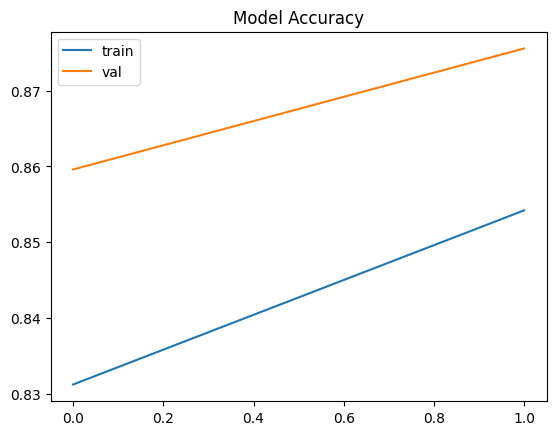

In [66]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend()
plt.title('Model Accuracy')
plt.show()

## Confusion matrix:

100/100 ━━━━━━━━━━━━━━━━━━━━ 45s 402ms/step
                                             precision    recall  f1-score   support

                      Tomato_Bacterial_spot       0.13      0.15      0.14       425
                        Tomato_Early_blight       0.07      0.05      0.06       200
                         Tomato_Late_blight       0.11      0.11      0.11       381
                           Tomato_Leaf_Mold       0.05      0.05      0.05       190
                  Tomato_Septoria_leaf_spot       0.11      0.10      0.10       354
Tomato_Spider_mites_Two_spotted_spider_mite       0.10      0.11      0.11       335
                        Tomato__Target_Spot       0.07      0.07      0.07       280
      Tomato__Tomato_YellowLeaf__Curl_Virus       0.19      0.19      0.19       641
                Tomato__Tomato_mosaic_virus       0.06      0.07      0.06        74
                             Tomato_healthy       0.12      0.11      0.12       318

                   

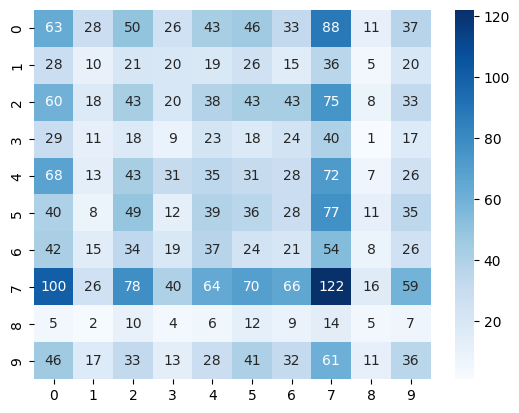

In [67]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

Y_pred = model.predict(val_gen)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(val_gen.classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
print(classification_report(val_gen.classes, y_pred, target_names=class_names))


# Grad-CAM Visualization

In [70]:
import cv2

def get_gradcam_heatmap(model, img_array, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer('Conv_1').output, model.output]
    )
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()



# Save Model & Make Gradio Demo

In [72]:
import gradio as gr

def predict_image(img):
    img = tf.image.resize(img, (224, 224))/255.0
    pred = model.predict(tf.expand_dims(img, axis=0))[0]
    return {class_names[i]: float(pred[i]) for i in range(len(class_names))}

demo = gr.Interface(fn=predict_image, inputs="image", outputs="label", title="Tomato Disease Detector")
demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c78f8d59d5dac29bb9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
